## **Library**

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

## **Upload Dataset**

In [2]:
from google.colab import files
csv = files.upload()

Saving polusi-jaksel-2010-2021-knn-full-labeled.csv to polusi-jaksel-2010-2021-knn-full-labeled.csv


## **Dataset**

In [36]:
df = pd.read_csv('polusi-jaksel-2010-2021-knn-full-labeled.csv')
df

,Unnamed: 0,tanggal,pm10,so2,co,o3,no2,max,critical,categori
0,0,2010-01-01,28.0,16.0,42.0,6.0,14.0,0.0,5.0,2.0
1,1,2010-01-02,28.0,16.0,42.0,6.0,14.0,0.0,5.0,2.0
2,2,2010-01-03,28.0,16.0,42.0,6.0,14.0,0.0,5.0,2.0
3,3,2010-01-04,28.0,16.0,42.0,6.0,14.0,0.0,5.0,2.0
4,4,2010-01-05,28.0,16.0,42.0,6.0,14.0,0.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...
4378,4378,2021-12-27,75.0,35.0,23.0,38.0,21.0,116.0,1.0,3.0
4379,4379,2021-12-28,51.0,42.0,13.0,17.0,18.0,74.0,1.0,1.0
4380,4380,2021-12-29,47.0,21.0,12.0,20.0,9.0,54.0,1.0,1.0
4381,4381,2021-12-30,60.0,21.0,15.0,19.0,13.0,60.0,3.0,1.0


In [37]:
df = df[['tanggal', 'categori']]
df.head()

,tanggal,categori
0,2010-01-01,2.0
1,2010-01-02,2.0
2,2010-01-03,2.0
3,2010-01-04,2.0
4,2010-01-05,2.0


In [38]:
df.tail()

,tanggal,categori
4378,2021-12-27,3.0
4379,2021-12-28,1.0
4380,2021-12-29,1.0
4381,2021-12-30,1.0
4382,2021-12-31,1.0


In [39]:
df.dtypes

tanggal      object
categori    float64
dtype: object

In [40]:
df = df.astype({"categori": 'float32'})
df["tanggal"] = pd.to_datetime(df.tanggal, format="%Y-%m-%d")

df.dtypes

tanggal     datetime64[ns]
categori           float32
dtype: object

In [41]:
df.index = df['tanggal']
df = df.drop(columns=['tanggal'])

In [42]:
df

,categori
tanggal,
2010-01-01,2.0
2010-01-02,2.0
2010-01-03,2.0
2010-01-04,2.0
2010-01-05,2.0
...,...
2021-12-27,3.0
2021-12-28,1.0
2021-12-29,1.0


In [43]:
df.describe()

,categori
count,4383.000000
mean,1.573866
std,0.742819
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,4.000000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


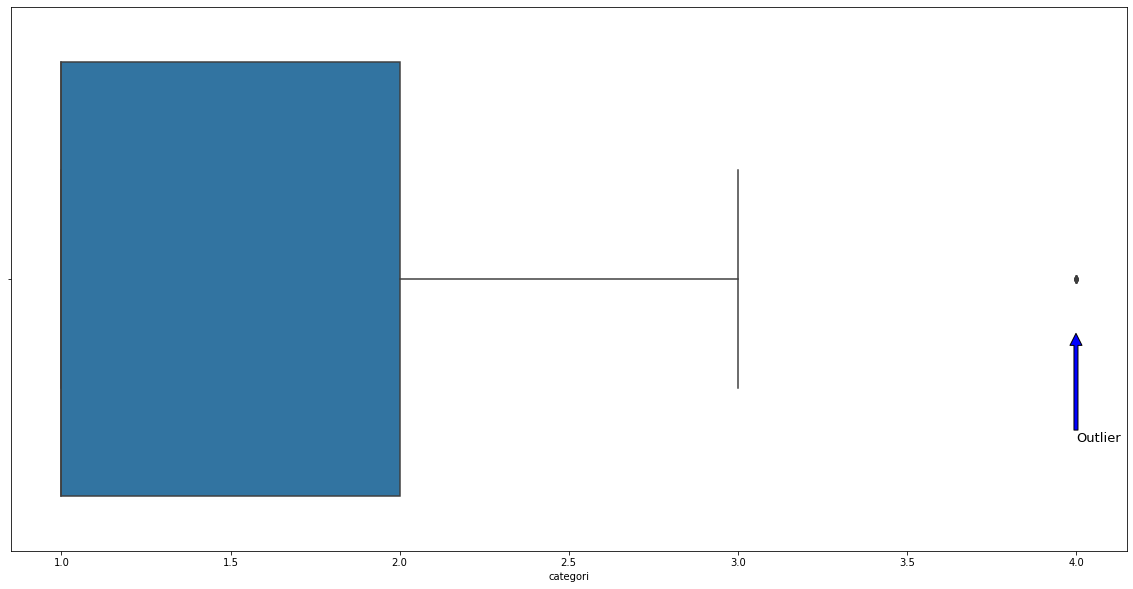

In [44]:
sns.boxplot(df['categori']) 
plt.annotate('Outlier', (df['categori'].describe()['max'],0.1), xytext = (df['categori'].describe()['max'],0.3), 
             arrowprops = dict(facecolor = 'blue'), fontsize = 13 ) 

IQR = df['categori'].describe()['75%'] - df['categori'].describe()['25%']

In [45]:
def detect_outliers(df,x): 
    Q1 = df[x].describe()['25%'] 
    Q3 = df[x].describe()['75%'] 
    IQR = Q3-Q1 
    return df[(df[x] < Q1-1.5*IQR) | (df[x] > Q3+1.5*IQR)]

In [47]:
outliers = detect_outliers(df, x ='categori')
outliers.describe()

,categori
count,9.0
mean,4.0
std,0.0
min,4.0
25%,4.0
50%,4.0
75%,4.0
max,4.0


In [48]:
df = df.drop((df[df['categori']>=outliers.min()[0]]).index, axis=0)

In [49]:
detect_outliers(df, x ='categori')

,categori
tanggal,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


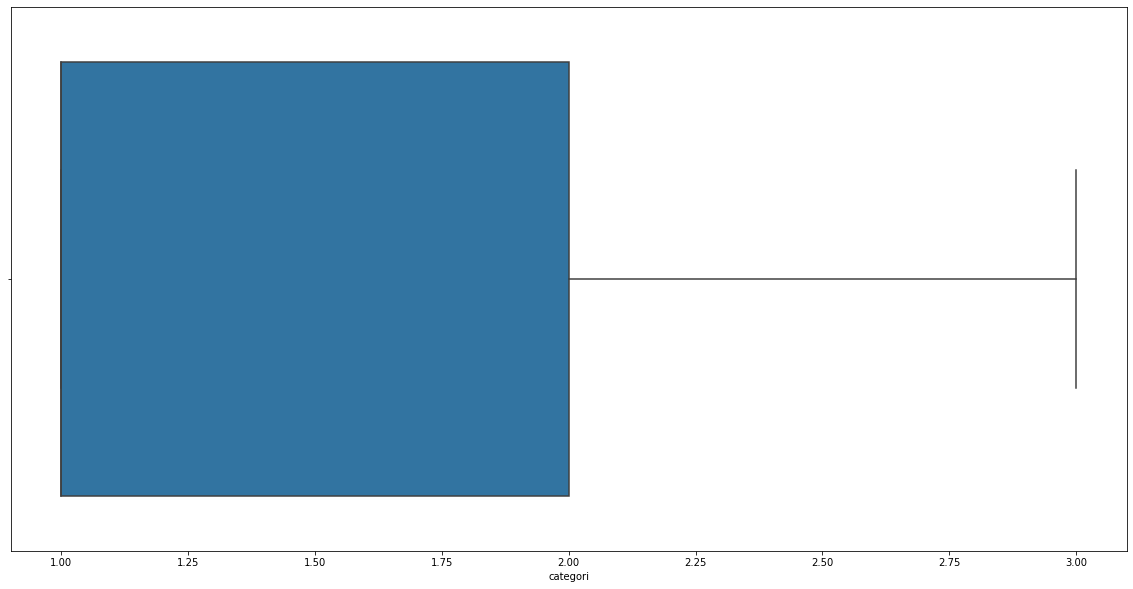

In [54]:
sns.boxplot(df['categori']) 
plt.show()

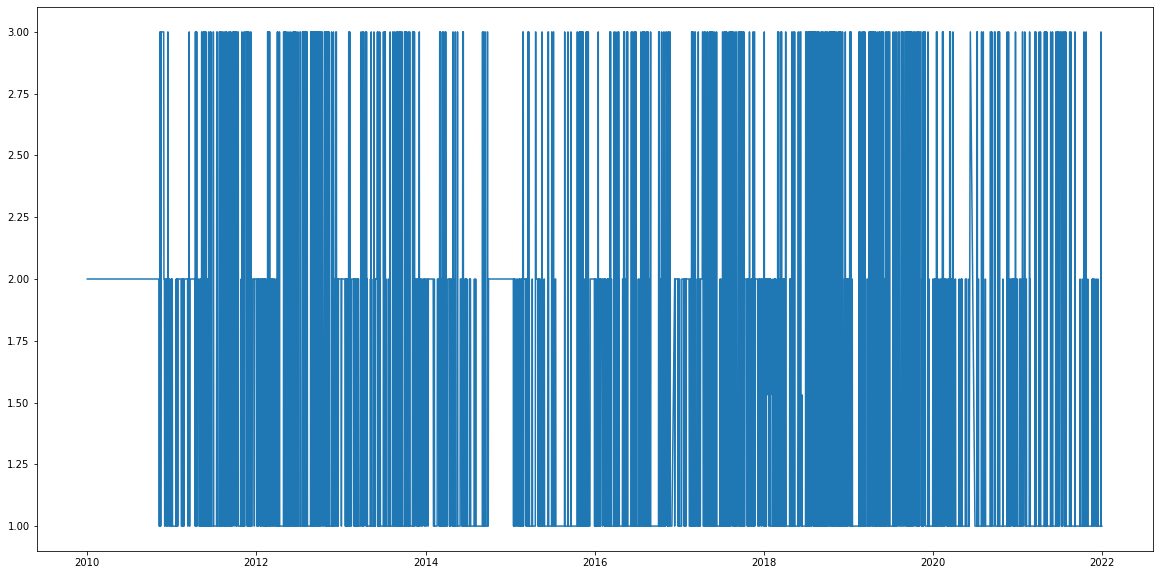

In [51]:
plt.plot(df["categori"],label='Kategori Polusi PerHari')

In [225]:
df_cat = df[['categori']]

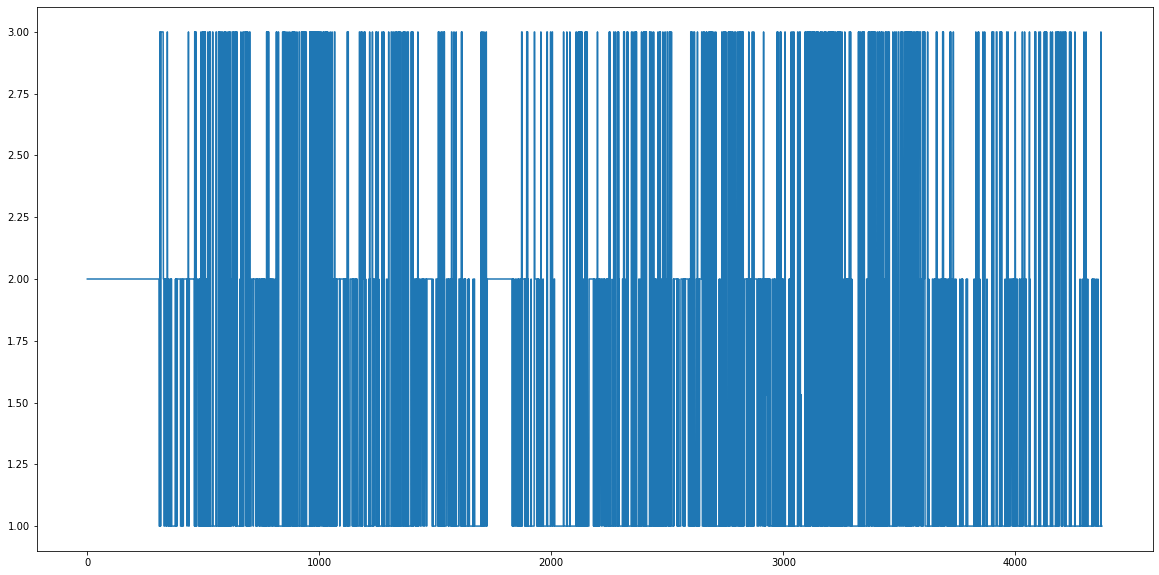

In [226]:
df_cat_val = df_cat.values
plt.plot(df_cat_val)

In [227]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
df_scaled = normalizer.fit_transform(np.array(df_cat_val).reshape(-1,1))

In [228]:
len(df_scaled), len(df_cat_val)

(4374, 4374)

In [229]:
#Defining test and train data sizes
train_size = int(len(df_scaled)*0.90)
test_size = len(df_scaled) - train_size

In [230]:
train_size,test_size

(3936, 438)

In [231]:
#Splitting data between train and test
df_train, df_test = df_scaled[0:train_size,:], df_scaled[train_size:len(df_scaled),:1]

In [232]:
len(df_train), len(df_test)

(3936, 438)

In [233]:
#creating dataset in time series for LSTM model 
def new_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [234]:
time_stamp = 100
X_train, y_train = new_ds(df_train,time_stamp)
X_test, y_test = new_ds(df_test,time_stamp)

In [235]:
X_train.shape,y_train.shape

((3835, 100), (3835,))

In [236]:
X_test.shape, y_test.shape

((337, 100), (337,))

In [237]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

## **Model**

In [238]:
# create and fit the LSTM network
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(tf.keras.layers.Dropout(0.2)) 
model.add(tf.keras.layers.LSTM(128, return_sequences = True))
model.add(tf.keras.layers.Dropout(0.2)) 
model.add(tf.keras.layers.LSTM(256))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='tanh'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 100, 64)           16896     
                                                                 
 dropout_23 (Dropout)        (None, 100, 64)           0         
                                                                 
 lstm_25 (LSTM)              (None, 100, 128)          98816     
                                                                 
 dropout_24 (Dropout)        (None, 100, 128)          0         
                                                                 
 lstm_26 (LSTM)              (None, 256)               394240    
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 1)                

In [239]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mse',optimizer='adam', metrics=['mae'])
history = model.fit(
    X_train,y_train,
    validation_data=(X_test,y_test),
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    )

Epoch 1/100
96/96 [==============================] - 7s 31ms/step - loss: 0.1303 - mae: 0.3024 - val_loss: 0.1620 - val_mae: 0.3617
Epoch 2/100
96/96 [==============================] - 2s 20ms/step - loss: 0.1259 - mae: 0.3012 - val_loss: 0.1606 - val_mae: 0.3409
Epoch 3/100
96/96 [==============================] - 2s 20ms/step - loss: 0.1257 - mae: 0.3006 - val_loss: 0.1617 - val_mae: 0.3315
Epoch 4/100
96/96 [==============================] - 2s 20ms/step - loss: 0.1237 - mae: 0.2945 - val_loss: 0.1592 - val_mae: 0.3344
Epoch 5/100
96/96 [==============================] - 2s 20ms/step - loss: 0.1237 - mae: 0.2938 - val_loss: 0.1564 - val_mae: 0.3388
Epoch 6/100
96/96 [==============================] - 2s 20ms/step - loss: 0.1214 - mae: 0.2911 - val_loss: 0.1577 - val_mae: 0.3213
Epoch 7/100
96/96 [==============================] - 2s 20ms/step - loss: 0.1220 - mae: 0.2898 - val_loss: 0.1528 - val_mae: 0.3335
Epoch 8/100
96/96 [==============================] - 2s 20ms/step - loss: 0.

In [240]:
# Convert the model.
import pathlib

export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: saved_model/1/assets


INFO:tensorflow:Assets written to: saved_model/1/assets


In [241]:
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

2070768

In [242]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

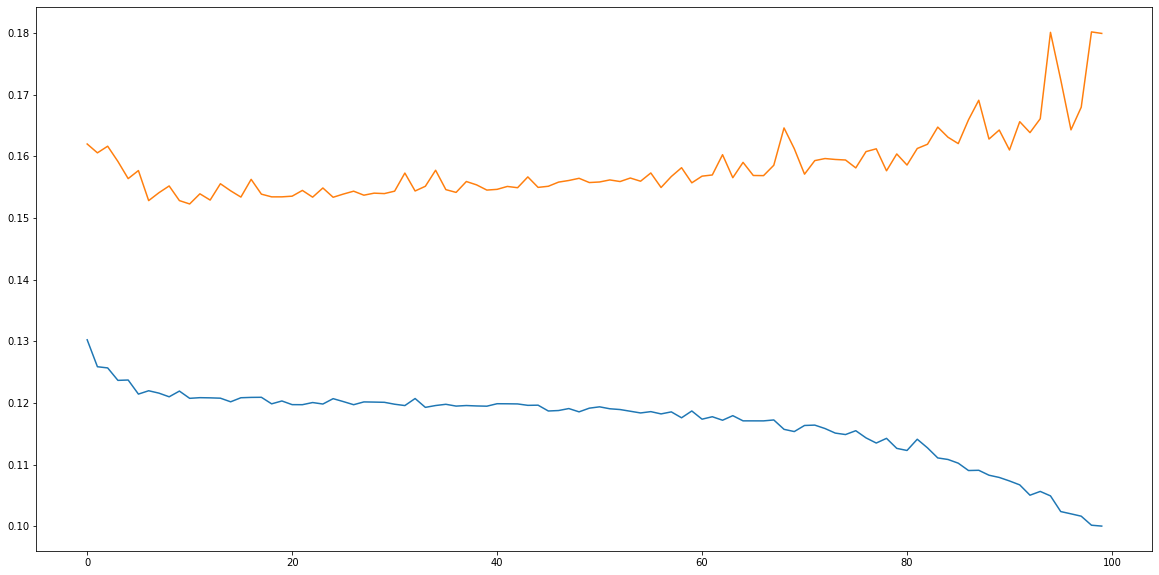

In [243]:
#Plotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)

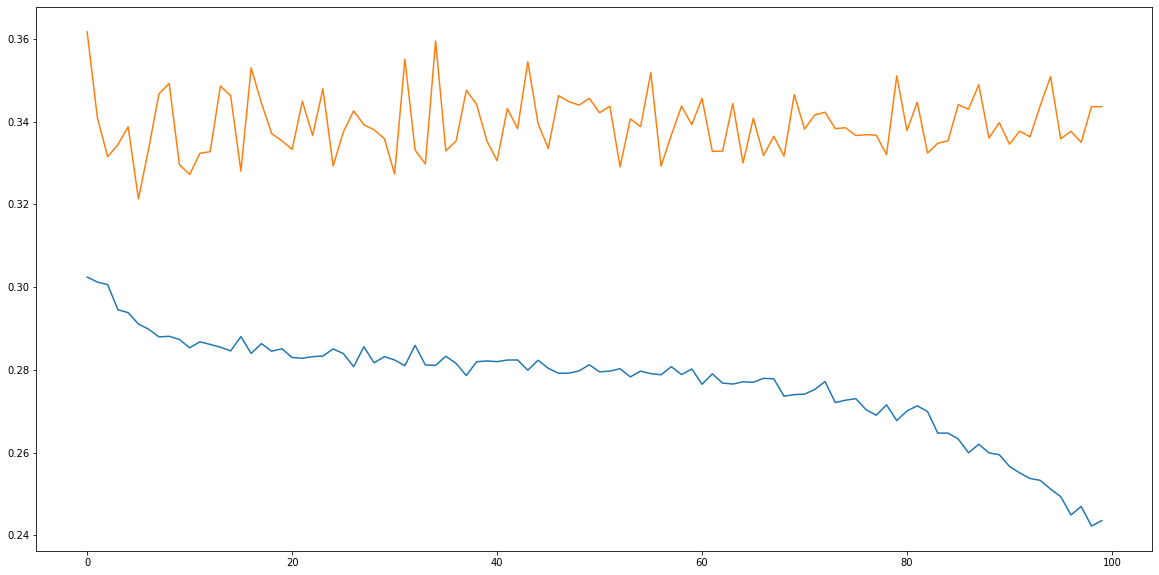

In [244]:
#Plotting accuracy, it shows that loss has decreased significantly and model trained well
mae = model.history.history['mae']
val_mae = model.history.history['val_mae']
plt.plot(mae)
plt.plot(val_mae)

In [245]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [246]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

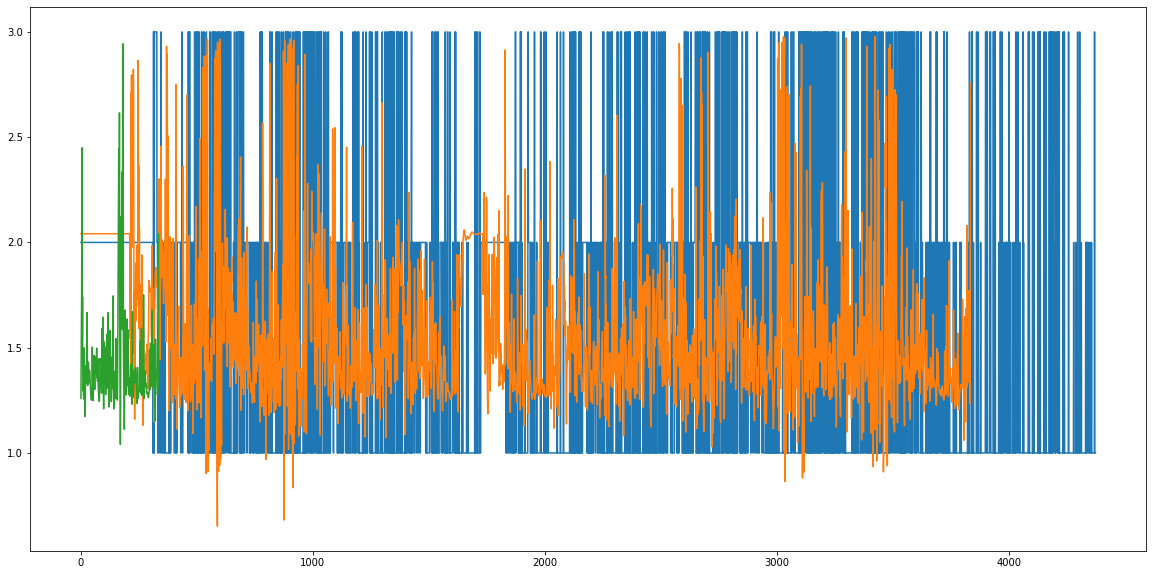

In [265]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(df_scaled))
plt.plot(train_predict) #Orange Training
plt.plot(test_predict) #Green Testing

In [248]:
type(train_predict)

numpy.ndarray

In [249]:
test = np.vstack((train_predict,test_predict))

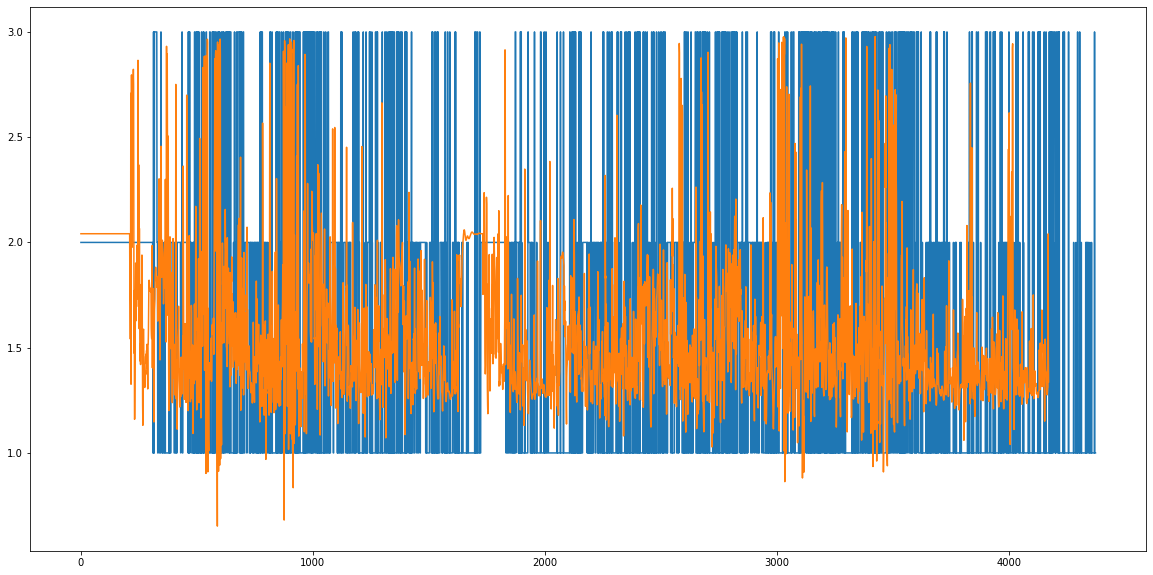

In [266]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(df_scaled))
plt.plot(test)

In [251]:
len(df_test)

438

In [252]:
#Getting the last 100 days records
fut_inp = df_test[len(df_test)-100:]
fut_inp = fut_inp.reshape(1,-1)

fut_inp.shape

(1, 100)

In [253]:
#Creating list of the last 100 data
tmp_inp = list(fut_inp)
tmp_inp = tmp_inp[0].tolist()

In [254]:
from datetime import datetime

# Predicting from last date of dataset untill today
date_dataset = '2021/12/31'
date_today = '2022/06/08'

# convert string to date object
d1 = datetime.strptime(date_dataset, "%Y/%m/%d")
d2 = datetime.strptime(date_today, "%Y/%m/%d")

# difference between dates in timedelta
delta = d2 - d1
delta = int(delta.days)
print(f'Difference is {delta} days')

Difference is 159 days


In [255]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
i=0
while(i<delta):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, time_stamp, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, time_stamp,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.16092362999916077], [0.16211746633052826], [0.18265102803707123], [0.20413221418857574], [0.21943539381027222], [0.24385607242584229], [0.26993343234062195], [0.28216394782066345], [0.28203848004341125], [0.2796972692012787], [0.28014075756073], [0.2825357913970947], [0.28546953201293945], [0.2893448770046234], [0.2946872413158417], [0.3008361756801605], [0.30662521719932556], [0.3114016354084015], [0.3147212564945221], [0.31578806042671204], [0.3137730360031128], [0.30879032611846924], [0.3022977113723755], [0.29656580090522766], [0.29339754581451416], [0.29349491000175476], [0.296436071395874], [0.30119839310646057], [0.30681106448173523], [0.3126950263977051], [0.31855154037475586], [0.3240642547607422], [0.32899966835975647], [0.3328075706958771], [0.3352119028568268], [0.3361044228076935], [0.3356281816959381], [0.33413830399513245], [0.33212944865226746], [0.3303721845149994], [0.32909125089645386], [0.32863327860832214], [0.32907652854919434], [0.3303358852863312], [0.332203

In [256]:
hasil = normalizer.inverse_transform(lst_output)
hasil = np.array(hasil)
hasil = hasil[-1]
hasil_float = hasil.astype(np.float32)
polusi = int(hasil_float)

# df.replace({'SEDANG':2, 'BAIK':1, 'TIDAK SEHAT':3, 'SANGAT TIDAK SEHAT':4,'BERBAHAYA':5}, inplace=True)

if polusi >= 1 and polusi < 2:
    print("Polusi = Baik ke Sedang")
elif polusi >= 2 and polusi < 3:
    print("Polusi = Sedang ke Tidak Sehat, Pakailah Maskerr !! ")
elif polusi >= 3 and polusi < 4:
    print("Polusi = Tidak Sehat, Pakailah Maskerr !!")
elif polusi >= 4 and polusi < 5:
    print("Polusi = Sangat Tidak Sehat, Pakailah Maskerr !!")
elif polusi >= 5:
    print("Polusi = Berbahaya, Pakailah Maskerr !!")


Polusi = Sedang ke Tidak Sehat, Pakailah Maskerr !! 


In [257]:
len(df_scaled)

4374

In [258]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,time_stamp+1)
plot_pred=np.arange(time_stamp+1,time_stamp+1+delta)

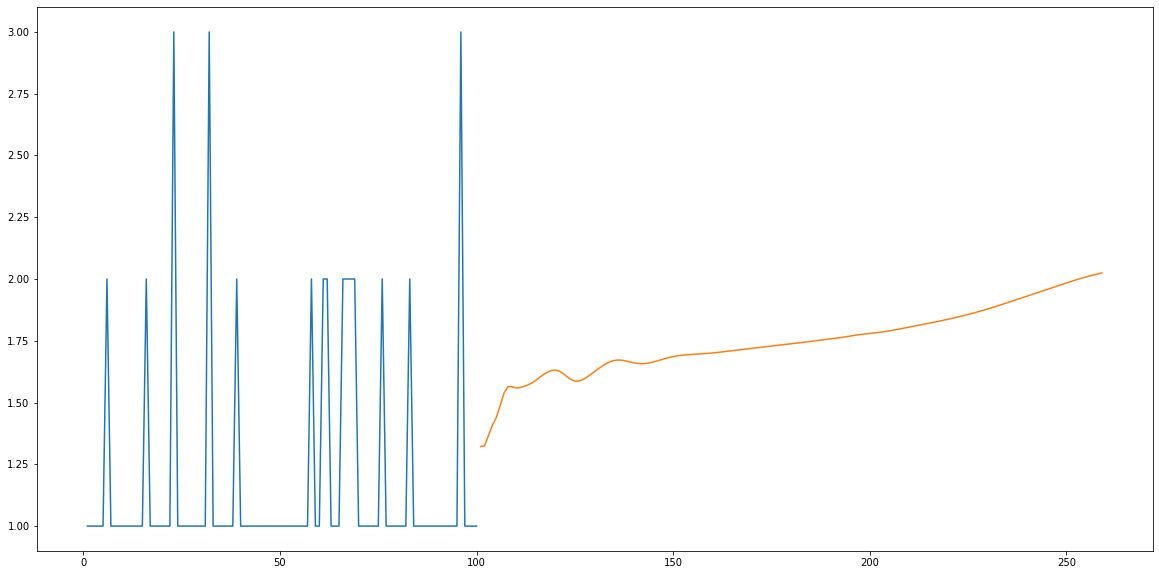

In [259]:
plt.plot(plot_new, normalizer.inverse_transform(df_scaled[len(df_scaled)-time_stamp:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [260]:
df_new = df_scaled.tolist()

In [261]:
len(df_new)

4374

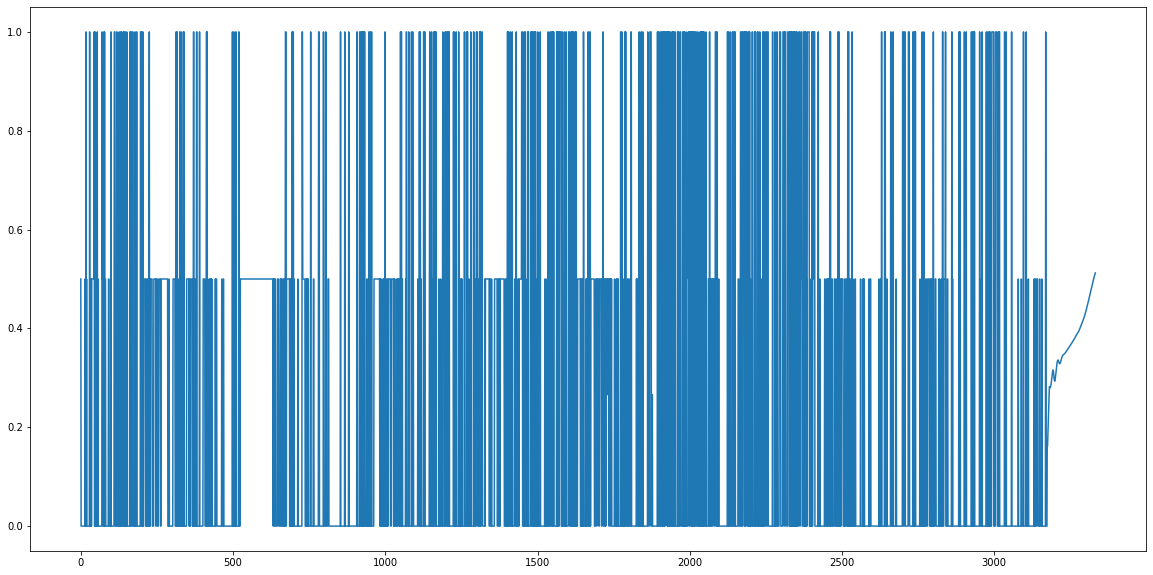

In [262]:
#Entends helps us to fill the missing value with approx value
df_new.extend(lst_output)
plt.plot(df_new[1200:])

In [263]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(df_new).tolist()

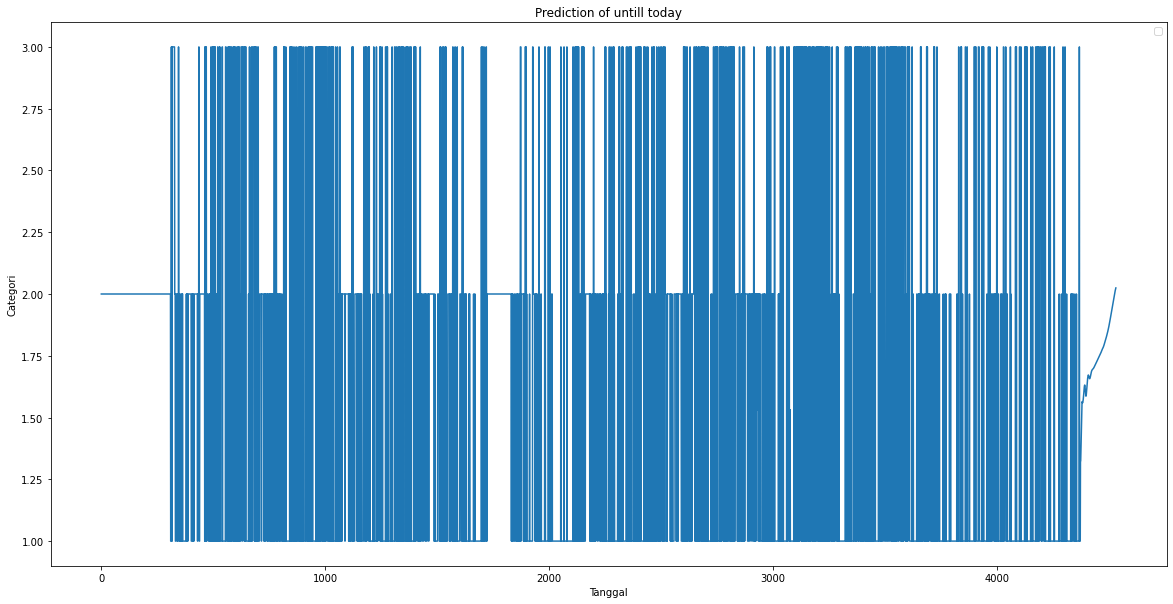

In [264]:
#Plotting final results with predicted value 2021/12/31 - 08/06/2022
plt.plot(final_graph,)
plt.ylabel("Categori")
plt.xlabel("Tanggal")
plt.title("Prediction of untill today")
plt.legend()